0.012707025647924669


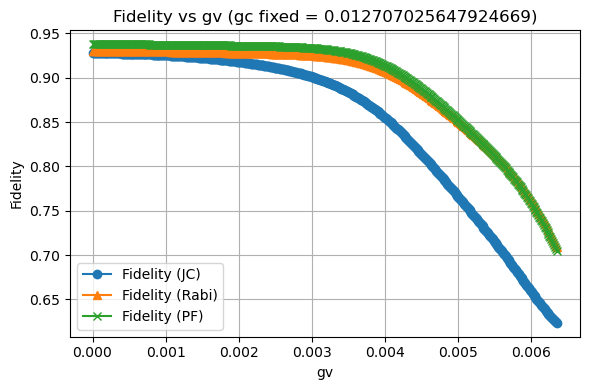

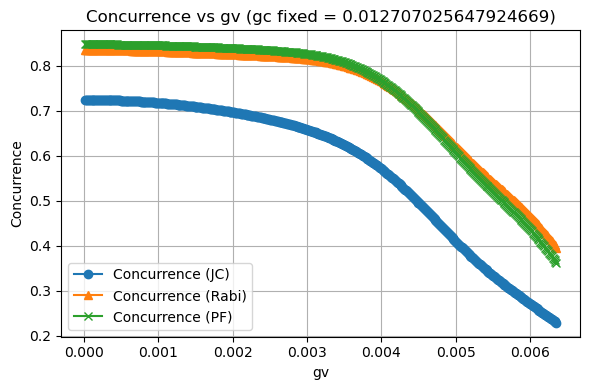

In [ ]:
import numpy as np
from qutip import *
from qutip import Qobj
from qutip.core.gates import *
import matplotlib.pyplot as plt
import json

pi = np.pi

# -----------------------------------------------------------
# Utility functions
# -----------------------------------------------------------
def wc_t(t, args=None):
    return 1

def w1_t(t, args=None):
    if t > T0_1 and t <= T0_1 + T_gate_1:
        return 1
    else:
        return 0

def w2_t(t, args=None):
    if t > T0_2 and t <= T0_2 + T_gate_2:
        return 1
    else:
        return 0

def read_json_to_dict(filename: str) -> dict:
    with open(filename, 'r') as f:
        return json.load(f)
    
def basis_state(dim, index):
    """Return computational basis vector for given index"""
    state = np.zeros((dim, 1))
    state[index, 0] = 1
    return state
    
def build_projector(dim, index_a, index_b):
    """Return projector |a><b| for given basis indices"""
    state_a = basis_state(dim, index_a)
    state_b = basis_state(dim, index_b)
    return state_a @ state_b.T.conj()

def build_polaritonic_vibrational(Nf, omega_1, omega_2, omega_3):
    """Construct vibrational Hamiltonian for 3 modes"""
    a1 = tensor(destroy(Nf), qeye(Nf), qeye(Nf))
    a2 = tensor(qeye(Nf), destroy(Nf), qeye(Nf))
    a3 = tensor(qeye(Nf), qeye(Nf), destroy(Nf))
    H_vib = omega_1 * a1.dag() * a1 + omega_2 * a2.dag() * a2 + omega_3 * a3.dag() * a3
    return H_vib
    
def build_polaritonic_vibronic_coupling(Nf, omega_v, S_12, S_13, S_14):


# -----------------------------------------------------------
# Load system parameters
# -----------------------------------------------------------
LiH_params = read_json_to_dict("LiH_params.json")

Nf = 4   # bosonic cutoff
# local operators
sz = sigmaz()
sm = destroy(2)
sp = sm.dag()
nq = sp * sm

am = destroy(Nf)
ap = am.dag()
nc = ap * am

# identities
Iq = qeye(2)
Ic = qeye(Nf)
Iv = qeye(Nf)

# fixed frequencies
omega_q = LiH_params["w_q1"]
omega_c = omega_q  # enforce resonance
omega_v = LiH_params["w_vib1"]
mu_eg = LiH_params["qubit_1_dipole_moments"]["mu_eg"]
mu_ee = LiH_params["qubit_1_dipole_moments"]["mu_e"]
mu_gg = LiH_params["qubit_1_dipole_moments"]["mu_g"]

# initial state: |e,g,0,0,0>
psi0 = tensor(basis(2,1), basis(2,0),
              basis(Nf,0), basis(Nf,0), basis(Nf,0))

# ideal Bell target
rho_qubits_ideal = ket2dm(
    tensor(phasegate(0), phasegate(pi/2)) *
    sqrtiswap() *
    tensor(basis(2,1), basis(2,0))
)

# time discretization
tlist = np.linspace(0, 1400, 5000)

# bare Hamiltonian (independent of gc, gv)
H_q1 = tensor(-omega_q/2 * sz, Iq, Iv, Iv, Ic)
H_q2 = tensor(Iq, -omega_q/2 * sz, Iv, Iv, Ic)
H_v1 = tensor(Iq, Iq, omega_v * nc, Iv, Ic)
H_v2 = tensor(Iq, Iq, Iv, omega_v * nc, Ic)
H_cav = tensor(Iq, Iq, Iv, Iv, omega_c * nc)
H_bare_total = H_q1 + H_q2 + H_v1 + H_v2 + H_cav

# -----------------------------------------------------------
# Parameter scan
# -----------------------------------------------------------
lv = 0.05
gc_fixed = np.sqrt( omega_c / 2) * lv * np.abs(mu_eg)  # <-- gc_fixed determined by lv, omega_c, and mu_eg

# dipole operator (fixed by lv) - used in Rabi and PF couplings
d_matrix_fixed = lv * np.array([[mu_gg, mu_eg], [mu_eg, mu_ee]])
d_qobj = Qobj(d_matrix_fixed)

print(gc_fixed)
gv_values = np.linspace(gc_fixed/1000, gc_fixed/2, 500)  # scan range for gv

fidelities_JC = []
concurrences_JC = []
fidelities_Rabi = []
concurrences_Rabi = []
fidelities_PF = []
concurrences_PF = []

for gv in gv_values:
    # interaction terms
    # JC bilinear coupling
    H_q1_cav_JC = gc_fixed * (tensor(sp, Iq, Iv, Iv, am) +
                              tensor(sm, Iq, Iv, Iv, ap)) 
    H_q2_cav_JC = gc_fixed * (tensor(Iq, sp, Iv, Iv, am) +
                              tensor(Iq, sm, Iv, Iv, ap))

    # Rabi bilinear coupling
    H_q1_cav_Rabi = np.sqrt(omega_c / 2) * tensor(d_qobj, Iq, Iv, Iv, (am + ap))
    H_q2_cav_Rabi = np.sqrt(omega_c / 2) * tensor(Iq, d_qobj, Iv, Iv, (am + ap))

    # Pauli-Fierz is Rabi + DSE
    H_q1_cav_PF = H_q1_cav_Rabi + 1/2 * tensor(d_qobj * d_qobj, Iq, Iv, Iv, Ic)
    H_q2_cav_PF = H_q2_cav_Rabi + 1/2 * tensor(Iq, d_qobj * d_qobj, Iv, Iv, Ic)

    H_q1_vib1 = gv * tensor(sp*sm, Iq, (am+ap), Iv, Ic)
    H_q2_vib2 = gv * tensor(Iq, sp*sm, Iv, (am+ap), Ic)

    H_bare_vc = H_bare_total + H_q1_vib1 + H_q2_vib2

    # gate times fixed by gc
    global T0_1, T0_2, T_gate_1, T_gate_2
    T0_1 = 20
    T_gate_1 = 338.91 #pi / (4 * np.abs(gc_fixed))
    T0_2 = T0_1 + T_gate_1
    T_gate_2 =  128.32 #pi / (2 * np.abs(gc_fixed))

    # time-dependent Hamiltonian
    H_t_JC = [[H_bare_vc, wc_t], [H_q1_cav_JC, w1_t], [H_q2_cav_JC, w2_t]]
    
    H_t_Rabi = [[H_bare_vc, wc_t], [H_q1_cav_Rabi, w1_t], [H_q2_cav_Rabi, w2_t]]
    
    H_t_PF = [[H_bare_vc, wc_t], [H_q1_cav_PF, w1_t], [H_q2_cav_PF, w2_t]]

    res_JC = mesolve(H_t_JC, psi0, tlist, [], e_ops=[])
    rho_final_JC = res_JC.states[-1]

    res_Rabi = mesolve(H_t_Rabi, psi0, tlist, [], e_ops=[])
    rho_final_Rabi = res_Rabi.states[-1]

    res_PF = mesolve(H_t_PF, psi0, tlist, [], e_ops=[])
    rho_final_PF = res_PF.states[-1]

    rho_qubits_JC = ptrace(rho_final_JC, [0,1])
    fidelities_JC.append(fidelity(rho_qubits_JC, rho_qubits_ideal))
    concurrences_JC.append(concurrence(rho_qubits_JC))

    rho_qubits_Rabi = ptrace(rho_final_Rabi, [0,1])
    fidelities_Rabi.append(fidelity(rho_qubits_Rabi, rho_qubits_ideal))
    concurrences_Rabi.append(concurrence(rho_qubits_Rabi))

    rho_qubits_PF = ptrace(rho_final_PF, [0,1])
    fidelities_PF.append(fidelity(rho_qubits_PF, rho_qubits_ideal))
    concurrences_PF.append(concurrence(rho_qubits_PF))


# -----------------------------------------------------------
# Plot results
# -----------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(gv_values, fidelities_JC, 'o-', label="Fidelity (JC)")
plt.plot(gv_values, fidelities_Rabi, '^-', label="Fidelity (Rabi)")
plt.plot(gv_values, fidelities_PF, 'x-', label="Fidelity (PF)")
plt.xlabel("gv")
plt.ylabel("Fidelity")
plt.title(f"Fidelity vs gv (gc fixed = {gc_fixed})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(gv_values, concurrences_JC, 'o-', label="Concurrence (JC)")
plt.plot(gv_values, concurrences_Rabi, '^-', label="Concurrence (Rabi)")
plt.plot(gv_values, concurrences_PF, 'x-', label="Concurrence (PF)")
plt.xlabel("gv")
plt.ylabel("Concurrence")
plt.title(f"Concurrence vs gv (gc fixed = {gc_fixed})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


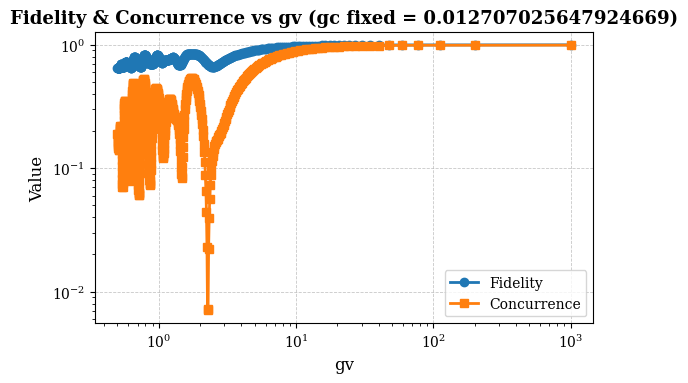

In [19]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(gc_fixed / gv_values, fidelities, 'o-', label="Fidelity")
ax.plot(gc_fixed / gv_values, concurrences, 's-', label="Concurrence")

ax.set_xlabel("gv")
ax.set_ylabel("Value")
ax.set_title(f"Fidelity & Concurrence vs gv (gc fixed = {gc_fixed})")
ax.legend()
ax.grid(True)

# Force scientific notation on x-axis
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3e'))
ax.loglog()
plt.tight_layout()
plt.show()

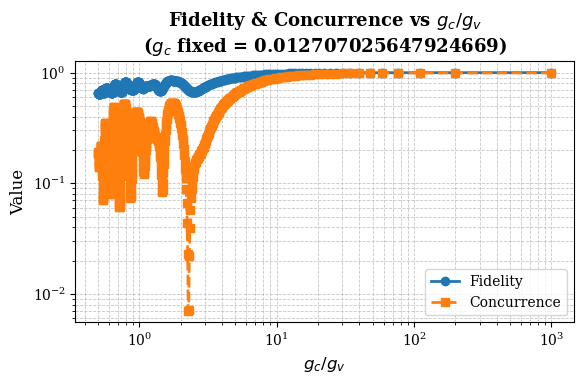

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# === Global Styling (applies to all figures) ===
plt.rcParams.update({
    "figure.figsize": (6, 4),          # consistent size
    "font.family": "serif",            # journal-style (use "Times New Roman" if required)
    "font.size": 12,                   # base font size
    "axes.labelsize": 12,              # axis labels
    "axes.titlesize": 13,              # title
    "axes.titleweight": "bold",
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2,              # thicker lines
    "lines.markersize": 6,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "grid.alpha": 0.7
})

# === Your plot ===
fig, ax = plt.subplots()

ax.plot(gc_fixed / gv_values, fidelities, 'o-', color="C0", label="Fidelity")
ax.plot(gc_fixed / gv_values, concurrences, 's--', color="C1", label="Concurrence")

ax.set_xlabel(r"$g_c / g_v$")
ax.set_ylabel("Value")
ax.set_title(f"Fidelity & Concurrence vs $g_c / g_v$\n($g_c$ fixed = {gc_fixed})")

ax.legend(frameon=True, loc="best")
ax.grid(True, which="both")

# Force scientific notation + log scales
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(1,5)
plt.tight_layout()

# === Save as vector graphics for publication ===
plt.savefig("fidelity_concurrence_vs_gv.pdf", bbox_inches="tight")   # vector, scalable
plt.savefig("fidelity_concurrence_vs_gv.png", dpi=600, bbox_inches="tight")  # high-res raster

plt.show()

